## Part 1 - Exploratory Data Analysis

### 1.0. Libraries and data files
***

In [1]:
!apt-get update
# importing the necessary spark environment and getting jdk
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://www-us.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop2.7'

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [67.0 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://arch

In [2]:
# getting the data
!pip install -q wget
!pip install -q findspark
import wget
data_19 = 'https://raw.githubusercontent.com/Gooner12/FIFA_2019/main/FIFA_19_players.csv'
data_21 = 'https://raw.githubusercontent.com/Gooner12/FIFA_2019/main/FIFA_21_players.csv'
dataset_19 = wget.download(data_19)
dataset_21 = wget.download(data_21)

In [3]:
import findspark
findspark.init()
#findspark.find()
from pyspark.sql import SparkSession

### 1.1 Data Exploration
***

In [4]:
# importing the 'FIFA_19.csv' as a Spark dataframe
spark = SparkSession.builder.appName('FIFA_19').config('spark.sql.caseSensitive', 'true').getOrCreate()
sc = spark.sparkContext
# not including header as data while reading so the header value is made true
df_19 = spark.read.format('csv').options(header='true', inferschema='true').load('FIFA_19_players.csv')
# caching the dataframe from faster processing when the number of operations grow later on this dataframe
df_19.persist()
df_19.show()

+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Rate| Body 

In [5]:
# viewing the execution plan
df_19.select('*').explain(True)

== Parsed Logical Plan ==
'Project [*]
+- Relation[ID#16,Name#17,Age#18,Photo#19,Nationality#20,Flag#21,Overall#22,Potential#23,Club#24,Club Logo#25,value(M)#26,wage(K)#27,Special#28,Preferred Foot#29,International Reputation#30,Weak Foot#31,Skill Moves#32,Work Rate#33,Body Type#34,Real Face#35,Position#36,Jersey Number#37,Joined#38,Loaned From#39,... 40 more fields] csv

== Analyzed Logical Plan ==
ID: int, Name: string, Age: int, Photo: string, Nationality: string, Flag: string, Overall: int, Potential: int, Club: string, Club Logo: string, value(M): string, wage(K): int, Special: int, Preferred Foot: string, International Reputation: int, Weak Foot: int, Skill Moves: int, Work Rate: string, Body Type: string, Real Face: string, Position: string, Jersey Number: int, Joined: string, Loaned From: string, ... 40 more fields
Project [ID#16, Name#17, Age#18, Photo#19, Nationality#20, Flag#21, Overall#22, Potential#23, Club#24, Club Logo#25, value(M)#26, wage(K)#27, Special#28, Preferred F

In [6]:
df_21 = spark.read.format('csv').options(header='true', inferschema='true').load('FIFA_21_players.csv')
df_21.persist()
df_21.show()

+---------+--------------------+-----------------+--------------------+---+----------+---------+---------+-----------+-------------------+--------------------+-----------+-------+---------+---------+--------+----------------+--------------+------------------------+---------+-----------+-------------+--------------------+---------+------------------+--------------------+-------------+------------------+-----------+----------+--------------------+---------------+--------------------+----+--------+-------+---------+---------+------+---------+-----------+----------+-----------+--------+--------------+--------------------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+---------

Merging the 2019 and 2021 dataframe to get the overall, potential, value in 2021 for every player.

In [7]:
# first renaming the id column in fifa 21 database same as the id column in fifa 19 database for merging later
df_21 = df_21.withColumnRenamed('sofifa_id','ID')
# joining the two dataframes on id and only merging overall, potential and value_eur to the fifa 19 database
df = df_19.join(df_21['ID','overall','potential','value_eur'], on=['ID'], how='left_outer')
df.persist()
df.show()

+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill

In [8]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- value(M): string (nullable = true)
 |-- wage(K): integer (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = true)
 |-- Contract 

Splitting the dataset:

To avoid data leakage we split the data into training and test dataset (validation) from the beginning before performing any steps related to data manipulations.

In [9]:
train_df, validation_df = df.randomSplit([0.8, 0.2], seed=2020)
train_df.persist()
validation_df.persist()

DataFrame[ID: int, Name: string, Age: int, Photo: string, Nationality: string, Flag: string, Overall: int, Potential: int, Club: string, Club Logo: string, value(M): string, wage(K): int, Special: int, Preferred Foot: string, International Reputation: int, Weak Foot: int, Skill Moves: int, Work Rate: string, Body Type: string, Real Face: string, Position: string, Jersey Number: int, Joined: string, Loaned From: string, Contract Valid Until: string, Height: double, Height(CM): double, Weight: double, Weight(KG): double, Crossing: int, Finishing: int, HeadingAccuracy: int, ShortPassing: int, Volleys: int, Dribbling: int, Curve: int, FKAccuracy: int, LongPassing: int, BallControl: int, Acceleration: int, SprintSpeed: int, Agility: int, Reactions: int, Balance: int, ShotPower: int, Jumping: int, Stamina: int, Strength: int, LongShots: int, Aggression: int, Interceptions: int, Positioning: int, Vision: int, Penalties: int, Composure: int, Marking: int, StandingTackle: int, SlidingTackle: in

Dealing Missing Values:

In this stage, we examine the dataset to see the necessary operations required on data to ease our analysis. Based on the examination, we develop separate transformers that can perform data manipulation to output the data in a desired format.

In [10]:
# checking the missing values
from pyspark.sql.functions import count, col, when
from pyspark.sql import functions as F
null_values_count = train_df.select([count(when(F.isnull(cols), cols)).alias(cols) for cols in train_df.columns])
null_values_count.show()

+---+----+---+-----+-----------+----+-------+---------+----+---------+--------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|Height|Height(CM)|Weight|Weight(KG)|Crossing|Finishing|Hea

In this analysis, the attributes that we are concerned with are player attributes that has impacts on players' gameplay such as 'Crossing', ShortPassing', etc. We are only concerned with forwards, midfielders and defenders not goalkeepers. It is seen that all attributes of interests have 33 missing values which include goalkeeping attributes too. So, we need to see if those missing values for different attributes belong to goalkeepers only before performing imputation or deletion of missing values.

In [11]:
# checking the missing values after removing goalkeepers
df_non_goalkeeper = train_df.filter(train_df['Position'] != 'GK')
df_non_goalkeeper.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in df_non_goalkeeper.columns]).show()

+---+----+---+-----+-----------+----+-------+---------+----+---------+--------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|Height|Height(CM)|Weight|Weight(KG)|Crossing|Finishing|Hea

It is seen that no missing values are present in our many attributes of interests for players belonging to positions other than goalkeepers. Important features in our analysis such as value(M), potential and value_eur, still have missing values, so appropriate operations to deal with those missing values should be performed before we proceed to other analysis.

Handling of missing values in value(M) column:

In [12]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

#df_view = 'soccer_analysis'
train_df.createOrReplaceTempView('soccer_analysis')

In [13]:
spark.sql("""
          Select * from soccer_analysis Where value_eur Is Not Null AND `value(M)` Is Null
          """).show()

+------+---------------+---+--------------------+------------+--------------------+-------+---------+---------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|           Name|Age|               Photo| Nationality|                Flag|Overall|Potential|           Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|    

It is seen that although we have missing values for players value in 2019, we can find the value of some of those players in 2021. Based on the value in 2021, we perform imputation of missing values in value column in 2019. To do that, we first compare the values in both years and calculate the percentage variation in values in those two years. Using that variation, we calculate the figures for missing values. 

The necessary operation is performed in a separate python file which we will import later.

In [14]:
spark.sql("""
          Select * from soccer_analysis Where `value(M)` Like '%K'
          """).show()

+-----+---------------+---+--------------------+-------------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|   ID|           Name|Age|               Photo|        Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak

All the issues seen above have to be dealt before proceeding to further analysis. To deal with those issues, a separate python script has been developed which we will import later on in this analysis to create dataframes that are free from complications seen above.

Creating Pipelines for Data Preprocessing:

In this stage, we create a pipelines for the regression task. 

Note: the modules used to generate the regression dataframe can be found in the github repository for this project.

Here, we import two python scripts containing transformers that we developed according to our examination in the previous section. The first python script is data_preprocessor.py which contains classes such as ValueManipulator, UnifyValue and ValueImputer. The second script is target_generator, and it contains classes such as ProfitGenerator and GrowthGenerator.

In [15]:
!rm -rf FIFA_2019

In [16]:
# only for google colab
!git clone https://github.com/Gooner12/FIFA_2019.git FIFA_2019
!mv "/content/FIFA_2019/data_preprocessor.py" "/content/"
!mv "/content/FIFA_2019/data_preprocessor_test.py" "/content/"
!mv "/content/FIFA_2019/target_generator.py" "/content/"
!mv "/content/FIFA_2019/multicollinearity_removal.py" "/content/"

Cloning into 'FIFA_2019'...
remote: Enumerating objects: 296, done.
remote: Counting objects: 100% (296/296), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 296 (delta 166), reused 197 (delta 105), pack-reused 0
Receiving objects: 100% (296/296), 5.05 MiB | 11.97 MiB/s, done.
Resolving deltas: 100% (166/166), done.


In [17]:
from pyspark.ml import Pipeline
import data_preprocessor, target_generator

# defining the stage that changes the units of players' values in 2021 along with renaming columns based on the year 
value_manipulation = data_preprocessor.ValueManipulator()
# defining the stage that standardises the players' values in 2019 to millions
value_standardisation = data_preprocessor.UnifyValue()
# defining the stage that imputes and removes missing values present in players' values in 2019 and 2021
value_imputation = data_preprocessor.ValueImputer()
# defining the stage that generates labels based on profits in two years for regression
regression_target = target_generator.ProfitGenerator()

DataFrame for Regression:

In [18]:
# creating a pipeline to generate dataframe for regression
pipeline_regression = Pipeline(stages=[value_manipulation, value_standardisation, value_imputation, regression_target])
# fitting the pipeline model and transforming the data as defined
pipeline_model = pipeline_regression.fit(train_df)
regression_df = pipeline_model.transform(train_df)
regression_df.persist()

The age bracket 1 has average variation of 1.725152
The age bracket 2 has average variation of 0.545784
The age bracket 3 has average variation of -0.032275
The age bracket 4 has average variation of -0.170250
The age bracket 5 has average variation of -0.260001
The age bracket 6 has average variation of 0.000000


DataFrame[ID: int, Name: string, Age: int, Photo: string, Nationality: string, Flag: string, Overall_2019: int, Potential_2019: int, Club: string, Club Logo: string, Value_2019(M): double, wage(K): int, Special: int, Preferred Foot: string, International Reputation: int, Weak Foot: int, Skill Moves: int, Work Rate: string, Body Type: string, Real Face: string, Position: string, Jersey Number: int, Joined: string, Loaned From: string, Contract Valid Until: string, Height: double, Height(CM): double, Weight: double, Weight(KG): double, Crossing: int, Finishing: int, HeadingAccuracy: int, ShortPassing: int, Volleys: int, Dribbling: int, Curve: int, FKAccuracy: int, LongPassing: int, BallControl: int, Acceleration: int, SprintSpeed: int, Agility: int, Reactions: int, Balance: int, ShotPower: int, Jumping: int, Stamina: int, Strength: int, LongShots: int, Aggression: int, Interceptions: int, Positioning: int, Vision: int, Penalties: int, Composure: int, Marking: int, StandingTackle: int, Sl

We record the above variations for each age group and use those values to impute missing values for the test dataset.

In [19]:
regression_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall_2019: integer (nullable = true)
 |-- Potential_2019: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- Value_2019(M): double (nullable = true)
 |-- wage(K): integer (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = true)

In [20]:
regression_df.show(5)

+-----+-----------------+---+--------------------+-----------+--------------------+------------+--------------+---------------+--------------------+------------------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+-------------------+
|   ID|             Name|Age|               Photo|Nationality|                Flag|Overall_2019|Potential_2019|           Club|           Club Logo|     Value_2019(M)|wage(K)

In [21]:
# checking the missing values in regression dataframe
regression_df.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in regression_df.columns]).show()

+---+----+---+-----+-----------+----+------------+--------------+----+---------+-------------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+-----------------+
| ID|Name|Age|Photo|Nationality|Flag|Overall_2019|Potential_2019|Club|Club Logo|Value_2019(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Un

It is seen that the column wage has 62 missing values, and this column might be important in predicting the players' price. 

In [22]:
# creating a view
regression_df.createOrReplaceTempView('soccer_analysis2')

# selecting the records containing null values in the wage column
spark.sql("""
          Select * from soccer_analysis2 Where `wage(K)` Is Null
          """).show()

+------+-----------------+---+--------------------+------------+--------------------+------------+--------------+----+--------------------+-------------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+-------------------+
|    ID|             Name|Age|               Photo| Nationality|                Flag|Overall_2019|Potential_2019|Club|           Club Logo|Value_2019(M)|wage(K)|Special|Preferred Foot|Internation

In [23]:
# finding the maximum value of a player whose wage is not disclosed
spark.sql("""
          Select MAX(`Value_2019(M)`), MIN(`Value_2019(M)`), MAX(Age), Min(Age) from soccer_analysis2 Where `wage(K)` Is Null
          """).show()

+------------------+------------------+--------+--------+
|max(Value_2019(M))|min(Value_2019(M))|max(Age)|min(Age)|
+------------------+------------------+--------+--------+
|             6.717|               0.0|      38|      18|
+------------------+------------------+--------+--------+



It is seen that the players whose wages are not disclosed are low value players ranging between 0 and 10 million. This might occur due to numerous reasons such as some players are just starting their professional football, some are at the end of their career or some are not good enough to negotiate their wage. These all reasons might led the players to accept the price their club has offered which is usually minimum wage. Thus, we impute the missing wage with the minimum wage amount.

In [24]:
# selecting the minimum wage
spark.sql("""
          Select MIN(`wage(K)`) from soccer_analysis2 Where `wage(K)` Is Not Null
          """).show()

+------------+
|min(wage(K))|
+------------+
|           1|
+------------+



In [25]:
# imputing the missing wage values with one
regression_df = regression_df.fillna(1, subset=['wage(K)'])
regression_df.persist()

DataFrame[ID: int, Name: string, Age: int, Photo: string, Nationality: string, Flag: string, Overall_2019: int, Potential_2019: int, Club: string, Club Logo: string, Value_2019(M): double, wage(K): int, Special: int, Preferred Foot: string, International Reputation: int, Weak Foot: int, Skill Moves: int, Work Rate: string, Body Type: string, Real Face: string, Position: string, Jersey Number: int, Joined: string, Loaned From: string, Contract Valid Until: string, Height: double, Height(CM): double, Weight: double, Weight(KG): double, Crossing: int, Finishing: int, HeadingAccuracy: int, ShortPassing: int, Volleys: int, Dribbling: int, Curve: int, FKAccuracy: int, LongPassing: int, BallControl: int, Acceleration: int, SprintSpeed: int, Agility: int, Reactions: int, Balance: int, ShotPower: int, Jumping: int, Stamina: int, Strength: int, LongShots: int, Aggression: int, Interceptions: int, Positioning: int, Vision: int, Penalties: int, Composure: int, Marking: int, StandingTackle: int, Sl

In [26]:
# checking the missing values in regression dataframe
regression_df.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in regression_df.columns]).show()

+---+----+---+-----+-----------+----+------------+--------------+----+---------+-------------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+-----------------+
| ID|Name|Age|Photo|Nationality|Flag|Overall_2019|Potential_2019|Club|Club Logo|Value_2019(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Un

In [27]:
regression_df.select(['Value_2019(M)', 'Value_2021(M)']).show(5)

+------------------+-------------+
|     Value_2019(M)|Value_2021(M)|
+------------------+-------------+
|              21.5|          5.5|
| 3.200000047683716|        0.975|
|1.7999999523162842|         0.65|
|              15.5|          4.2|
|              77.0|         46.0|
+------------------+-------------+
only showing top 5 rows



Data Visualisation:

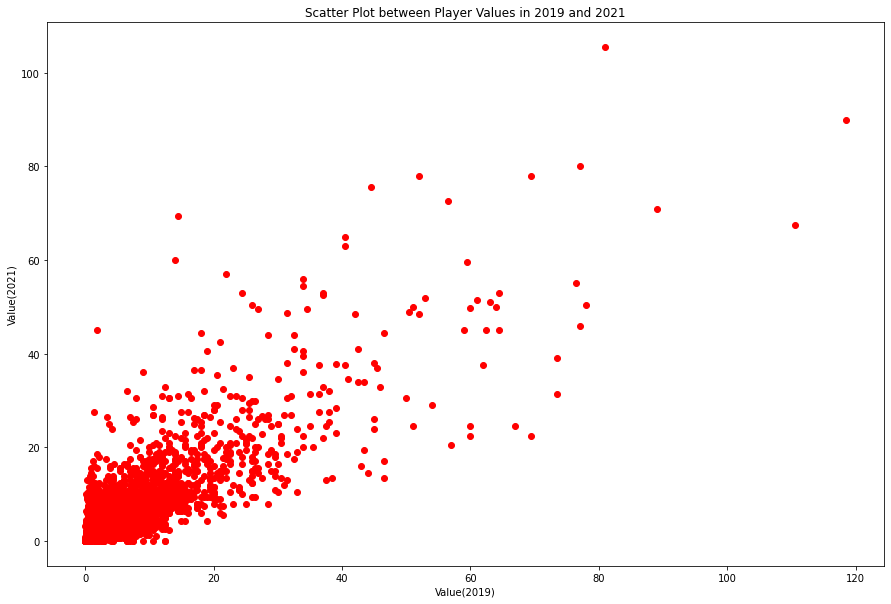

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

pd_df = regression_df.toPandas()

# plotting a scatter plot to see the realtionship between player values in 2019 and 2021
fig = plt.figure(figsize=(15,10))
plt.scatter(pd_df['Value_2019(M)'], pd_df['Value_2021(M)'], color='r')
plt.xlabel('Value(2019)')
plt.ylabel('Value(2021)')
plt.title('Scatter Plot between Player Values in 2019 and 2021')
plt.show()

There is a linear relationship between values in two years, and we can see some anomalies as well. Those anomalies are due to some players who have grown rapidly in the two year period causing their values to rise quickly. In our analysis, we are keeping those anomalies.

### 3.1 Data Preparation

We try to predict the value of players in two years using the attributes that might impact players' price tags and values.
***

Function:

Feature Engineering:

In this step, we try to find the features that are most correlated with the target (Gain in Two Years). From this step, we will only pick up those attributes who have at least of 10% correlation with the target whether negative or positive. We use both spearman and pearson correlation to determine this. Any attribute that pass this criterion on any of those two tests will be accepted into the next step.

In [29]:
from pyspark.ml.feature import VectorAssembler

features_col = [ 'Value_2021(M)', 'Age', 'Value_2019(M)', 'wage(K)', 'International Reputation', 'Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'Overall_2019']

vec_assembler = VectorAssembler(inputCols=features_col, outputCol='features')
df_class = vec_assembler.transform(regression_df).select('features')
df_class.show(5)

+--------------------+
|            features|
+--------------------+
|[5.5,34.0,21.5,21...|
|[0.975,34.0,3.200...|
|[0.65,32.0,1.7999...|
|[4.2,34.0,15.5,80...|
|[46.0,33.0,77.0,4...|
+--------------------+
only showing top 5 rows



In [30]:
regression_df[features_col].show(5)

+-------------+---+------------------+-------+------------------------+----------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+------------+
|Value_2021(M)|Age|     Value_2019(M)|wage(K)|International Reputation|Height(CM)|Weight(KG)|Crossing|Finishing|HeadingAccuracy|ShortPassing|Volleys|Dribbling|Curve|FKAccuracy|LongPassing|BallControl|Acceleration|SprintSpeed|Agility|Reactions|Balance|ShotPower|Jumping|Stamina|Strength|LongShots|Aggression|Interceptions|Positioning|Vision|Penalties|Composure|Marking|StandingTackle|SlidingTackle|Overall_2019|
+-------------+---+------------------+-------+------------------------+----------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+--

In [30]:
from pyspark.ml.stat import Correlation
#r1 = Correlation.corr(df_class, 'features', method='pearson').head()
pearson_corr = Correlation.corr(df_class, 'features', 'pearson').collect()[0][0]
print(str(pearson_corr))
#print('Pearson correlation matrix:\n' + str(r1[0]))

DenseMatrix([[ 1.        , -0.02934086,  0.85460062, ...,  0.08321708,
               0.06385752,  0.56292012],
             [-0.02934086,  1.        ,  0.08252199, ...,  0.21033237,
               0.17942919,  0.45383611],
             [ 0.85460062,  0.08252199,  1.        , ...,  0.09384732,
               0.06659134,  0.64133327],
             ...,
             [ 0.08321708,  0.21033237,  0.09384732, ...,  1.        ,
               0.9663477 ,  0.26372863],
             [ 0.06385752,  0.17942919,  0.06659134, ...,  0.9663477 ,
               1.        ,  0.22098014],
             [ 0.56292012,  0.45383611,  0.64133327, ...,  0.26372863,
               0.22098014,  1.        ]])


In [31]:
# alternative way to calculate pearson correlation
import six
for i in regression_df[features_col].columns:
  # checking if the instance is of string type and using six to write compatible code for both python2.x and 3.x
  if not(isinstance(regression_df[features_col].select(i).take(1)[0][0], six.string_types)):
    print('Correlation to Value_2021(M) for ', i, regression_df[features_col].stat.corr('Value_2021(M)',i, 'pearson'))

Correlation to Value_2021(M) for  Value_2021(M) 1.0
Correlation to Value_2021(M) for  Age -0.02934085684907212
Correlation to Value_2021(M) for  Value_2019(M) 0.8546006157224946
Correlation to Value_2021(M) for  wage(K) 0.6808465886334129
Correlation to Value_2021(M) for  International Reputation 0.5099652344508421
Correlation to Value_2021(M) for  Height(CM) 0.019506023912340336
Correlation to Value_2021(M) for  Weight(KG) 0.03099685734877797
Correlation to Value_2021(M) for  Crossing 0.2874365142249914
Correlation to Value_2021(M) for  Finishing 0.2637731577390949
Correlation to Value_2021(M) for  HeadingAccuracy 0.18980982632812496
Correlation to Value_2021(M) for  ShortPassing 0.41475269062889886
Correlation to Value_2021(M) for  Volleys 0.2861783821392116
Correlation to Value_2021(M) for  Dribbling 0.36774194025550405
Correlation to Value_2021(M) for  Curve 0.3080917757194512
Correlation to Value_2021(M) for  FKAccuracy 0.2549355821339627
Correlation to Value_2021(M) for  LongPass

In [32]:
# creating a datafame from the dense matrix
import pandas as pd

labels = features_col 
#creating a dataframe from the dense matrix
pearson_df = pd.DataFrame(pearson_corr.toArray(), index = [i for i in labels], columns = [i for i in labels])
pearson_df

,Value_2021(M),Age,Value_2019(M),wage(K),International Reputation,Height(CM),Weight(KG),Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Overall_2019
Value_2021(M),1.000000,-0.029341,0.854601,0.680847,0.509965,0.019506,0.030997,0.287437,0.263773,0.189810,0.414753,0.286178,0.367742,0.308092,0.254936,0.306699,0.442918,0.201353,0.209651,0.197619,0.484521,0.110897,0.309578,0.078525,0.240458,0.079928,0.289784,0.153093,0.107427,0.295962,0.338861,0.226464,0.432045,0.103123,0.083217,0.063858,0.562920
Age,-0.029341,1.000000,0.082522,0.146249,0.252109,0.038594,0.215011,0.263349,0.143272,0.345351,0.307423,0.240938,0.103124,0.254136,0.302939,0.305683,0.250400,-0.209303,-0.203642,-0.016106,0.452994,-0.092406,0.304297,0.187992,0.226229,0.357421,0.271750,0.400122,0.282108,0.188270,0.237577,0.250366,0.462302,0.235847,0.210332,0.179429,0.453836
Value_2019(M),0.854601,0.082522,1.000000,0.851186,0.661856,0.029326,0.064959,0.309579,0.300053,0.243947,0.461370,0.343286,0.387082,0.345728,0.304055,0.350689,0.483537,0.176240,0.179804,0.197542,0.557508,0.104540,0.358406,0.106165,0.260649,0.120876,0.337237,0.196205,0.128227,0.330831,0.381390,0.281630,0.504069,0.119265,0.093847,0.066591,0.641333
wage(K),0.680847,0.146249,0.851186,1.000000,0.666186,0.036264,0.083137,0.289348,0.248871,0.255537,0.413443,0.303565,0.333343,0.309802,0.265636,0.318940,0.428370,0.114620,0.123595,0.152421,0.506937,0.077150,0.329153,0.118185,0.215762,0.134223,0.298707,0.215117,0.154729,0.286299,0.331714,0.257135,0.461964,0.141114,0.124402,0.103695,0.579739
International Reputation,0.509965,0.252109,0.661856,0.666186,1.000000,0.034375,0.091928,0.265627,0.224408,0.244080,0.365530,0.314291,0.279972,0.306655,0.279667,0.297679,0.370535,0.029202,0.024480,0.100116,0.453749,0.049511,0.317387,0.105871,0.123190,0.125254,0.282284,0.211322,0.141776,0.255753,0.312109,0.285559,0.441724,0.131446,0.107576,0.085830,0.501756
Height(CM),0.019506,0.038594,0.029326,0.036264,0.034375,1.000000,0.390681,-0.253301,-0.142911,0.295034,-0.094349,-0.121377,-0.237387,-0.202286,-0.172704,-0.095211,-0.143066,-0.296088,-0.221693,-0.341645,0.010931,-0.430465,-0.041346,0.021042,-0.054765,0.346157,-0.147534,0.141279,0.091106,-0.203153,-0.190138,-0.104397,0.025425,0.106027,0.105326,0.087549,0.064847
Weight(KG),0.030997,0.215011,0.064959,0.083137,0.091928,0.390681,1.000000,-0.253209,-0.125233,0.522962,-0.073906,-0.084492,-0.278615,-0.197374,-0.151073,-0.087182,-0.133587,-0.416227,-0.314476,-0.497085,0.117734,-0.649210,0.056721,0.105627,0.030185,0.728578,-0.098683,0.323864,0.179187,-0.185909,-0.203954,-0.056625,0.118921,0.189434,0.181718,0.153650,0.185873
Crossing,0.287437,0.263349,0.309579,0.289348,0.265627,-0.253301,-0.253209,1.000000,0.415616,-0.132268,0.630928,0.470809,0.713830,0.715287,0.616939,0.593376,0.682208,0.438856,0.394106,0.549254,0.461872,0.436026,0.458187,-0.025179,0.350282,-0.177226,0.549454,0.105799,0.125419,0.586245,0.644976,0.371340,0.470495,0.085198,0.084339,0.077693,0.497748
Finishing,0.263773,0.143272,0.300053,0.248871,0.224408,-0.142911,-0.125233,0.415616,1.000000,0.005552,0.397019,0.814595,0.707577,0.614549,0.536365,0.217078,0.646730,0.376291,0.351385,0.485232,0.350967,0.311375,0.701628,-0.052126,0.119996,-0.122715,0.803607,-0.193548,-0.492973,0.820110,0.654575,0.745732,0.412716,-0.504979,-0.558711,-0.587595,0.374241
HeadingAccuracy,0.189810,0.345351,0.243947,0.255537,0.244080,0.295034,0.522962,-0.132268,0.005552,1.000000,0.134873,0.065602,-0.130695,-0.090802,-0.073791,0.058831,0.071020,-0.335260,-0.238608,-0.349912,0.410205,-0.469844,0.193697,0.355815,0.166929,0.644568,0.032170,0.464932,0.286120,-0.018202,-0.076923,0.110968,0.349397,0.273774,0.258724,0.234112,0.469971


Attributes that fail to satisfy the criterion from the pearson test are height(cm), weight(kg), age,  jumping, strength, standing tackle and sliding tackle.

In [33]:
# creating a dataframe based on the spearman correlation
spearman_corr = Correlation.corr(df_class, 'features', 'spearman').collect()[0][0]
spearman_df = pd.DataFrame(spearman_corr.toArray(), index = [i for i in labels], columns = [i for i in labels])
spearman_df

,Value_2021(M),Age,Value_2019(M),wage(K),International Reputation,Height(CM),Weight(KG),Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Overall_2019
Value_2021(M),1.000000,-0.037896,0.851381,0.616626,0.322520,0.022542,0.041015,0.389117,0.338126,0.264236,0.569650,0.339326,0.544547,0.385887,0.303722,0.422148,0.627895,0.282627,0.303412,0.279664,0.590204,0.130946,0.438079,0.114295,0.322464,0.121237,0.400519,0.221021,0.197822,0.410158,0.420901,0.285645,0.537446,0.173341,0.184747,0.155413,0.733979
Age,-0.037896,1.000000,0.226539,0.330895,0.263147,0.059256,0.224728,0.287254,0.156078,0.361312,0.309974,0.248133,0.137861,0.265109,0.299758,0.312604,0.262030,-0.133288,-0.117972,0.025354,0.477566,-0.075417,0.338072,0.233972,0.292634,0.376328,0.301937,0.419010,0.313031,0.237241,0.256551,0.246844,0.469212,0.266230,0.250103,0.220834,0.478293
Value_2019(M),0.851381,0.226539,1.000000,0.770595,0.390213,0.053977,0.120335,0.474962,0.417826,0.388138,0.690943,0.439639,0.616331,0.483920,0.403858,0.533295,0.742257,0.262819,0.284914,0.312476,0.767050,0.114023,0.575148,0.199292,0.433165,0.254072,0.519600,0.356125,0.284702,0.516567,0.534300,0.373296,0.717735,0.247502,0.248244,0.203678,0.936279
wage(K),0.616626,0.330895,0.770595,1.000000,0.400577,0.055790,0.122165,0.418636,0.339682,0.379609,0.576199,0.388301,0.493765,0.424794,0.358626,0.452989,0.611140,0.134516,0.154332,0.218190,0.667558,0.063630,0.499289,0.194229,0.325060,0.256203,0.443531,0.351494,0.275548,0.433249,0.445629,0.346769,0.627805,0.237294,0.246130,0.210298,0.793401
International Reputation,0.322520,0.263147,0.390213,0.400577,1.000000,0.037139,0.094971,0.271571,0.214898,0.234556,0.367484,0.281382,0.287136,0.291211,0.253455,0.307306,0.359679,0.028623,0.026123,0.097163,0.417217,0.051304,0.339118,0.120457,0.126082,0.136084,0.293545,0.233872,0.171287,0.265939,0.302431,0.259584,0.419062,0.153300,0.146731,0.121543,0.440824
Height(CM),0.022542,0.059256,0.053977,0.055790,0.037139,1.000000,0.532859,-0.303183,-0.162324,0.404685,-0.127543,-0.154026,-0.279494,-0.253285,-0.232651,-0.118908,-0.177956,-0.377151,-0.276546,-0.437883,0.010604,-0.571210,-0.044831,0.057145,-0.069709,0.509760,-0.167186,0.190270,0.137991,-0.208926,-0.228486,-0.130991,0.026048,0.158223,0.166814,0.136381,0.070405
Weight(KG),0.041015,0.224728,0.120335,0.122165,0.094971,0.532859,1.000000,-0.232215,-0.107894,0.526153,-0.078043,-0.085853,-0.253339,-0.190852,-0.163915,-0.076522,-0.125329,-0.394531,-0.287722,-0.471396,0.115495,-0.633926,0.068444,0.142069,0.025752,0.721807,-0.077507,0.323776,0.201733,-0.138834,-0.190166,-0.055865,0.116221,0.218846,0.220278,0.187305,0.177311
Crossing,0.389117,0.287254,0.474962,0.418636,0.271571,-0.303183,-0.232215,1.000000,0.385850,-0.119654,0.617981,0.458959,0.696791,0.706541,0.608382,0.569735,0.670421,0.451068,0.411439,0.531240,0.472866,0.414814,0.468344,-0.011605,0.380354,-0.180517,0.534650,0.110535,0.144120,0.550865,0.623073,0.357116,0.473124,0.094717,0.098393,0.103711,0.513418
Finishing,0.338126,0.156078,0.417826,0.339682,0.214898,-0.162324,-0.107894,0.385850,1.000000,0.021915,0.363358,0.813392,0.692457,0.590029,0.523266,0.192560,0.630231,0.382219,0.357739,0.465771,0.350736,0.290873,0.689347,-0.047976,0.120457,-0.113384,0.781802,-0.183298,-0.473457,0.823407,0.613525,0.751384,0.397421,-0.500876,-0.538929,-0.569258,0.376923
HeadingAccuracy,0.264236,0.361312,0.388138,0.379609,0.234556,0.404685,0.526153,-0.119654,0.021915,1.000000,0.124745,0.051994,-0.107191,-0.090790,-0.084265,0.065530,0.074199,-0.320941,-0.219408,-0.338937,0.394432,-0.466491,0.209679,0.380391,0.160059,0.663874,0.054086,0.471824,0.331472,0.033876,-0.069626,0.101895,0.345865,0.324560,0.329788,0.298896,0.467498


Attributes that fail to satisfy the criterion from the spearman test are age, height(cm) and weight(kg).

Based on the above two tests, we remove age, height(cm) and weight(kg) from the prediction analysis in further steps.

In [31]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

def steps_processor(features_col, df):

  # creating a feature vector
  vec_assembler = VectorAssembler(inputCols=features_col, outputCol='features')
  df_class = vec_assembler.transform(df).select('features','Value_2021(M)')

  # scaling the feature vector
  standardscaler = StandardScaler().setInputCol('features').setOutputCol('Scaled_features')
  raw_data = standardscaler.fit(df_class).transform(df_class)

  # splitting the dataset
  #train, test = raw_data.randomSplit([0.7, 0.3], seed=2020)
  return raw_data

In [32]:
features_col = ['Value_2019(M)', 'wage(K)', 'International Reputation', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'Overall_2019']


train = steps_processor(features_col, regression_df)
train.persist()

DataFrame[features: vector, Value_2021(M): double, Scaled_features: vector]

Next, we compare three baseline models and select the best baseline model for further tuning in the later step.

In [33]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='Scaled_features', labelCol='Value_2021(M)', maxIter=100)
model_lr = lr.fit(train)
predict_train_lr = model_lr.transform(train)
print('Coefficients: ' + str(model_lr.coefficients))
print('Intercept: ' + str(model_lr.intercept))

Coefficients: [5.305167598330932,-0.7947722834595766,-0.3696066166291787,-0.005857281495031108,0.09858900182546544,0.011301145068078253,0.10152706348692736,-0.15038473277969092,0.29740497987784786,0.11981275019025076,-0.14902507195050968,-0.238799595942276,0.12948390626720158,0.003205910319503543,-0.025788325121589507,0.1475457228026546,-0.034996662541552176,-0.010785660022525102,-0.08963335406316963,-0.13478333660360292,-0.09283955112053562,-0.14122087069179387,-0.05624496100576014,0.04151673937914908,-0.10520003363095155,-0.06606511142086403,-0.008529229262405916,-0.05849229998306371,0.41472180489685934,0.24598097515864642]
Intercept: -1.0572855375767893


From the coefficient values, it is seen that some attributes have positive while some have negative relationship with the players value in 2021. Also, when all the attributes are not passed to the model, then the value of a player is determined to be -1.698 million. Another important information obtained from the coefficients is that in our dataset, there might be a chance that multicollinearity exists because the coefficients for international reputation is -0.0585. It means that as the reputation grows the player value falls which is counter intuitive to our general understanding. So, we need to take a test for the multicollinearity. Furthermore, removing multicollinearity might not increase the model performance because there is another highly multicollinear feature counterpart that is helping the model to retain its performance. But the interpretability of the model will increase by removing multicollinearity.

In [34]:
import multicollinearity_removal

remover = multicollinearity_removal.MultiCollinearityRemover()
regression_df_new = remover.vif_setter(regression_df[features_col])

The dataframe has 12834 rows and 30 columns
+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|[21.0,4.0,77.0,70...|              21.5|
|[10.0,1.0,62.0,64...| 3.200000047683716|
|[7.0,1.0,51.0,39....|1.7999999523162842|
|[80.0,3.0,92.0,67...|              15.5|
|[405.0,5.0,84.0,9...|              77.0|
+--------------------+------------------+
only showing top 5 rows

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[21.5,4.0,77.0,70...|   21|
|[3.20000004768371...|   10|
|[1.79999995231628...|    7|
|[15.5,3.0,92.0,67...|   80|
|[77.0,5.0,84.0,94...|  405|
+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[21.5,21.0,77.0,7...|    4|
|[3.20000004768371...|    1|
|[1.79999995231628...|    1|
|[15.5,80.0,92.0,6...|    3|
|[77.0,405.0,84.0,...|    5|
+--------------------+-----+
only s

Now, we remove these collinear features from the validation set too along with other necessary transformation. 

In [35]:
import data_preprocessor_test

# creating a list containing the variations for different age brackets obtained from the last step
variation_list = [1.725152, 0.545784, -0.032275, -0.170250, -0.260001, 0.000000]

# defining the stage that changes the units of players' values in 2021 along with renaming columns based on the year 
value_manipulation = data_preprocessor_test.ValueManipulator()
# defining the stage that standardises the players' values in 2019 to millions
value_standardisation = data_preprocessor_test.UnifyValue()
# defining the stage that imputes and removes missing values present in players' values in 2019 and 2021
value_imputation = data_preprocessor_test.ValueImputer(variation_list)
# defining the stage that generates labels based on profits in two years for regression
regression_target = target_generator.ProfitGenerator()

In [36]:
# creating a pipeline to generate dataframe for regression
pipeline_regression = Pipeline(stages=[value_manipulation, value_standardisation, value_imputation, regression_target])
# fitting the pipeline model and transforming the data as defined
pipeline_model_test = pipeline_regression.fit(validation_df)
regression_validation_df = pipeline_model_test.transform(validation_df)
regression_validation_df.persist()

# imputing the missing values for wage
regression_validation_df = regression_validation_df.fillna(1, subset=['wage(K)'])
regression_validation_df.persist()

# selecting only those features that have been selected for the training dataset along with removed multicollinear features
# updating the features_col
features_col_update = ['Value_2019(M)', 'wage(K)', 'International Reputation', 
                      'Crossing', 'HeadingAccuracy', 
                      'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'Aggression', 
                      'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking']
validation = steps_processor(features_col, regression_validation_df)
validation.persist()

DataFrame[features: vector, Value_2021(M): double, Scaled_features: vector]

In [37]:
# checking the missing values in regression dataframe
regression_validation_df.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in regression_validation_df.columns]).show()

+---+----+---+-----+-----------+----+------------+--------------+----+---------+-------------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+-----------------+
| ID|Name|Age|Photo|Nationality|Flag|Overall_2019|Potential_2019|Club|Club Logo|Value_2019(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Un

In [38]:
validation.show()

+--------------------+-------------+--------------------+
|            features|Value_2021(M)|     Scaled_features|
+--------------------+-------------+--------------------+
|[15.5,110.0,4.0,8...|          5.0|[2.63069263474366...|
|[1.0,5.0,2.0,73.0...|          0.4|[0.16972210546733...|
|[10.0,41.0,2.0,68...|          5.5|[1.69722105467333...|
|[2.20000004768371...|          1.5|[0.37338864012111...|
|[3.20000004768371...|          5.5|[0.54311074558844...|
|[1.10000002384185...|        0.325|[0.18669432006055...|
|[2.29999995231628...|          1.3|[0.39036083448188...|
|[5.0,30.0,2.0,52....|          2.1|[0.84861052733666...|
|[1.29999995231628...|        0.725|[0.22063872901455...|
|[4.5,30.0,2.0,78....|          4.3|[0.76374947460299...|
|[3.79999995231628...|          1.8|[0.64494399268288...|
|[4.30000019073486...|          2.3|[0.72980508588145...|
|[1.5,23.0,1.0,68....|          0.5|[0.25458315820099...|
|[34.0,240.0,4.0,5...|         21.0|[5.77055158588933...|
|[7.0,48.0,2.0

Now we generate a feature vector from the new dataframe not containing multicollinear feautres. Then we start buidling model from that data.

In [40]:
regression_df.columns

['Value_2019(M)',
 'wage(K)',
 'International Reputation',
 'Crossing',
 'HeadingAccuracy',
 'Volleys',
 'Dribbling',
 'Curve',
 'FKAccuracy',
 'LongPassing',
 'Reactions',
 'Balance',
 'ShotPower',
 'Jumping',
 'Stamina',
 'Strength',
 'Aggression',
 'Positioning',
 'Vision',
 'Penalties',
 'Composure',
 'Marking']

In [ ]:
train = steps_processor(features_col_update, regression_df)
train.persist()

lr = LinearRegression(featuresCol='Scaled_features', labelCol='Value_2021(M)', maxIter=100)
model_lr = lr.fit(train)
predict_train_lr = model_lr.transform(train)

Also, we use Mean Absolute Error as our metric instead of Root Mean Squared Error as a small fluctuations in bias is not that sensistive.

In [41]:
training_summary = model_lr.summary
#print('RMSE: %f' % training_summary.rootMeanSquaredError)
print('r2: %f' % training_summary.r2)
print('MAE: %f' % training_summary.meanAbsoluteError)

r2: 0.746778
MAE: 1.195794


We are using both RMSE and MAE since MAE is robust to outliers and RMSE is not. As we saw previously in the visualisation that our data has some outliers too, so using both these metrics is useful. To note, we are not seeing the effect of outliers too much in our data from these two metrics.

In [42]:
# finding the mean, min and max to compare MAE and measure performance
train.describe().show()

+-------+-----------------+
|summary|    Value_2021(M)|
+-------+-----------------+
|  count|            12834|
|   mean|2.581318918497739|
| stddev|5.342704683255118|
|    min|              0.0|
|    max|            105.5|
+-------+-----------------+



It is seen that our MAE is not small compared to the mean value. But the r2 is good. Also, we can see that we have outliers from the maximum and minimum values. MAE is affected by outliers too, however, we choose to keep outliers in our analysis.

R square value of 0.7614, which is 76.14% variability in players' value in 2021 is explained using the above attributes and remaining 13.8% variability could be defined through other attributes, seems good. And our RMSE of 2.56 considering the min, max and mean is not that bad. However, this result is for training set, we still need to see how our model performs for the test set.

In [45]:
from pyspark.ml.evaluation import RegressionEvaluator

predict_validation_lr = model_lr.transform(validation)
predict_validation_lr.select('prediction','Value_2021(M)','features').show(5)
lr_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Value_2021(M)', metricName='r2')
print('R2 on validation data = %g' % lr_evaluator.evaluate(predict_validation_lr))

+------------------+-------------+--------------------+
|        prediction|Value_2021(M)|            features|
+------------------+-------------+--------------------+
| 8.974163858957553|          5.0|[15.5,110.0,4.0,8...|
| 0.528170275940127|          0.4|[1.0,5.0,2.0,73.0...|
| 7.096486284173619|          5.5|[10.0,41.0,2.0,68...|
|2.7966276541969335|          1.5|[2.20000004768371...|
|3.0352958190275077|          5.5|[3.20000004768371...|
+------------------+-------------+--------------------+
only showing top 5 rows

R2 on validation data = 0.782667


In [46]:
validation_result = model_lr.evaluate(validation)
#print('RMSE on validation data = %g' % validation_result.rootMeanSquaredError)
print('MAE on validation data = %g' % validation_result.meanAbsoluteError)

MAE on validation data = 1.12449


In our test set, the model's predictibility has improved to 76.35% from 76.14%, but the RMSE error has increased by 0.09 from 2.56 to 2.65. At the same time, our mean absolute error has decreased by around 0.02. Overall, this is neither a bad performance nor huge improvement when the model is used on the test set.

In the previous step, we used hold out validation technique, and estimated the model's performance. In the next step, we use cross validated training set and measure the performance. This is because our dataset is small, and performing holdout validation might not generalise the model. So, we need k-fold cross validation for this purpose.

In [48]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol='Scaled_features', labelCol='Value_2021(M)', lr.maxIter=10)
lr_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Value_2021(M)', metricName='r2')
# building a paramter grid with only the default value for linear regression
grid_lr = ParamGridBuilder().build()
cv = CrossValidator(estimator=lr, evaluator=lr_evaluator, estimatorParamMaps=grid_lr,\
                    parallelism=2, numFolds=10, seed=2020)
model_lr = cv.fit(train)
print('The average R-squared (R2) value from 10 folds is ',model_lr.avgMetrics[0])
# transforming the training data using the best model from cross validation
# in our case, the only model we get from cross validation is our best model. So, putting .bestModel is optional 
predict_train_lr = model_lr.bestModel.transform(train)

The average R-squared (R2) value from 10 folds is  0.7359793773668817


In [50]:
# transforming the validation data with the best model from cross validation
predict_validation_lr = model_lr.bestModel.transform(validation)
print('MAE on validation data = %g' % lr_evaluator.evaluate(predict_validation_lr))
lr_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Value_2021(M)', metricName='r2')
print('R2 on validation data = %g' % lr_evaluator.evaluate(predict_validation_lr))

MAE on validation data = 1.12449
R2 on validation data = 0.782667


In our results, we can see the performance on the validation set when using hold-out validation and cross validation is same for R2 and MAE. This is because our only model which is our best model is similar to model obtained from hold out validation. However, from cross validation, we obtained the average R2 value from 10 fold validation as 0.73598 when we all the default values for linear regression are used. While from hold out validation we obtained R2 value as 0.74678. This suggest that we got lucky in the hold out validation and cross validation is generalising the model's results. So, we use cross validation for other models.

Compared to ordinary regression and ridge regression, the MAE has improved while RMSE has worsen a bit at alpha = 0.3. This may be due to the fact that RMSE penalises large error differences caused by anomalies. If we don't like large error differences caused by anomalies then we should use RMSE or if we don't care about large difference MAE is suitable. 